In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-08-23 15:51:09


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

from invisible_cities.types.ic_types          import Counter
from invisible_cities.types.ic_types          import NN
from invisible_cities.types.ic_types          import xy
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf
from   invisible_cities.reco import pmaps_functions_c  as cpmp
from   invisible_cities.reco import pmaps_functions  as pmp
from   invisible_cities.reco.xy_algorithms      import corona

from   invisible_cities.evm.ic_containers           import S12Params 
from   invisible_cities.evm.ic_containers          import CalibVectors
from   invisible_cities.evm.ic_containers          import DeconvParams
from   invisible_cities.evm.ic_containers          import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
from   invisible_cities.types.ic_types import Counter
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.icaro.pmaps_mpl import plot_s2si_map
from   invisible_cities.icaro.mpl_functions   import draw_pmt_map

In [88]:
from invisible_cities.io.pmap_io import load_pmaps
from invisible_cities.io.pmap_io import s1_s2_si_from_pmaps
from invisible_cities.evm.pmaps import S12
from invisible_cities.evm.pmaps import S1
from invisible_cities.evm.pmaps import S2
from invisible_cities.evm.pmaps import S2Si
import invisible_cities.evm.event_model as evm
from invisible_cities.evm.event_model import HitCollection
from invisible_cities.evm.event_model import Hit
from invisible_cities.evm.event_model import Voxel
from invisible_cities.evm.event_model import BHit

from invisible_cities.evm.event_model import Track
from invisible_cities.evm.event_model import Blob
from invisible_cities.evm.event_model import TrackCollection
from invisible_cities.evm.event_model import VoxelCollection

In [80]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmZeroCharge
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound
from invisible_cities.core.exceptions        import ClusterEmptyList
from invisible_cities.core.exceptions        import XYRecoFail

In [51]:
from invisible_cities.icaro.hvt_mpl import draw_voxels
from invisible_cities.icaro.hvt_mpl import draw_voxels2
from invisible_cities.icaro.hvt_mpl import plot_hits_3D
from invisible_cities.icaro.hvt_mpl import draw_tracks
import invisible_cities.icaro.hvt_mpl as hvt

In [87]:
import invisible_cities.reco.paolina_functions as plf
import invisible_cities.reco.paolina_functions as paf

In [6]:
run_number = -4446
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [7]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

### Debug flag

In [68]:
DEB = True

### Reco algorithms

In [8]:
def barycenter(pos, qs):
    """pos = column np.array --> (matrix n x 2)
       ([x1, y1],
        [x2, y2]
        ...
        [xs, ys])
       qs = vector (q1, q2...qs) --> (1xn)

        """

    if not len(pos): raise SipmEmptyList
    if sum(qs) == 0: raise SipmZeroCharge
    mu  = np.average( pos           , weights=qs, axis=0)
    std = np.average((pos - mu) ** 2, weights=qs, axis=0)
    # For uniformity of interface, all xy algorithms should return a
    # list of clusters. barycenter always returns a single clusters,
    # but we still want it in a list.
    return [Cluster(sum(qs), xy(*mu), xy(*std), len(qs))]

    #return [Cluster(sum(qs), XY(*mu), std, len(qs))]

def discard_sipms(sis, pos, qs):
    return np.delete(pos, sis, axis=0), np.delete(qs, sis)

def get_nearby_sipm_inds(cs, d, pos, qs):
    """return indices of sipms less than d from (xc,yc)"""
    return np.where(np.linalg.norm(pos - cs, axis=1) <= d)[0]



In [65]:
def corona(pos, qs,
           Qthr           =  0 * units.pes,
           Qlm            =  5 * units.pes,
           lm_radius      =  0 * units.mm,
           new_lm_radius  = 15 * units.mm,
           msipm          =  3):
    """
    corona creates a list of Clusters by
    first , identifying hottest_sipm, the sipm with max charge in qs (must be > Qlm)
    second, calling barycenter() on the pos and qs SiPMs within lm_radius of hottest_sipm to
            find new_local_maximum.
    third , calling barycenter() on all SiPMs within new_lm_radius of new_local_maximum
    fourth, recording the Cluster found by barycenter if the cluster contains at least msipm
    fifth , removing (nondestructively) the sipms contributing to that Cluster
    sixth , repeating 1-5 until there are no more SiPMs of charge > Qlm

    arguments:
    pos   = column np.array --> (matrix n x 2)
            ([x1, y1],
             [x2, y2],
             ...     ,
             [xs, ys])
    qs    = vector (q1, q2...qs) --> (1xn)
    Qthr  = charge threshold, ignore all SiPMs with less than Qthr pes
    Qlm   = charge threshold, every Cluster must contain at least one SiPM with charge >= Qlm
    msipm = minimum number of SiPMs in a Cluster
    lm_radius = radius, find new_local_maximum by taking the barycenter of SiPMs within
                lm_radius of the max sipm. new_local_maximum is new in the sense that the
                prev loc max was the position of hottest_sipm. (Then allow all SiPMs with
                new_local_maximum of new_local_maximum to contribute to the pos and q of the
                new cluster).

                ***In general lm_radius should typically be set to 0, or some value slightly
                larger than pitch or pitch*sqrt(2).***

                ***If lm_radius is set to a negative number, the algorithm will simply return
                the overall barycenter all the SiPms above threshold.***


                ---------
                    This kwarg has some physical motivation. It exists to try to partially
                compensate problem that the NEW tracking plane is not continuous even though light
                can be emitted by the EL at any (x,y). When lm_radius < pitch, the search for SiPMs
                that might contribute pos and charge to a new Cluster is always centered about
                the position of hottest_sipm. That is, SiPMs within new_lm_radius of
                hottest_sipm are taken into account by barycenter(). In contrast, when
                lm_radius = pitch or pitch*sqrt(2) the search for SiPMs contributing to the new
                cluster can be centered at any (x,y). Consider the case where at a local maximum
                there are four nearly equally 'hot' SiPMs. new_local_maximum would yield a pos,
                pos1, between these hot SiPMs. Searching for SiPMs that contribute to this
                cluster within new_lm_radius of pos1 might be better than searching searching for
                SiPMs  within new_lm_radius of hottest_sipm.
                    We should be aware that setting lm_radius to some distance greater than pitch,
                we allow new_local_maximum to assume any (x,y) but we also create the effect that
                depending on where new_local_maximum is, more or fewer SiPMs will be
                within new_lm_radius. This effect does not exist when lm_radius = 0
                    lm_radius can always be set to 0 mm, but setting it to 15 mm (slightly larger
                than 10mm * sqrt(2)), should not hurt.

    new_lm_radius = radius, find a new cluster by calling barycenter() on pos/qs of SiPMs within
                    new_lm_radius of new_local_maximum
    returns
    c    : a list of Clusters

    Usage Example
    In order to create each Cluster from a 3x3 block of SiPMs (where the center SiPM has more
    charge than the others), one would call:
    corona(pos, qs,
           Qthr           =  K1 * units.pes,
           Qlm            =  K2 * units.pes,
           lm_radius      =  0  * units.mm , # must be 0
           new_lm_radius  =  15 * units.mm , # must be 10mm*sqrt(2) or some number slightly larger
           msipm          =  K3)
    """
    if DEB:
        print('corona: SiPMs with signal in slice = {} '.format(len(pos)))
    
    if not len(pos): raise SipmEmptyList
    if sum(qs) == 0: raise SipmZeroCharge

    above_threshold = np.where(qs >= Qthr)[0]            # Find SiPMs with qs at least Qthr
    pos, qs = pos[above_threshold], qs[above_threshold]  # Discard SiPMs with qs less than Qthr

    if not len(pos): raise SipmEmptyListAboveQthr
    if sum(qs) == 0: raise SipmZeroChargeAboveQthr

    if DEB:
        print('above threshold qs > {}: SiPMs with signal in slice = {} '.format(Qthr, len(pos)))
        print('above threshold: qs = {}\n '.format(qs))


    # if lm_radius or new_lm_radius is negative, just call overall barycenter
    if lm_radius < 0 or new_lm_radius < 0:
        return barycenter(pos, qs)


    c  = []
    # While there are more local maxima
    ll=0
    while len(qs) > 0:
        hottest_sipm = np.argmax(qs)       # SiPM with largest Q
        
        if DEB:
            print('--loop = {} hottest_sipm = {} treshold = {}'.format(ll, hottest_sipm, Qlm))
            print('qs = {}, pos = {}'.format(qs[hottest_sipm], pos[hottest_sipm]))
        
        if qs[hottest_sipm] < Qlm: 
            if DEB:
                print('hottest sipm has not enough charge, exit loop')
            break   # largest Q remaining is negligible

        # find new local maximum of charge considering all SiPMs within lm_radius of hottest_sipm
        within_lm_radius   = get_nearby_sipm_inds(pos[hottest_sipm], lm_radius, pos, qs)
        new_local_maximum  = barycenter(pos[within_lm_radius], qs[within_lm_radius])[0].posxy
        
        if DEB:
            print('first ring with radius = {}'.format(lm_radius))
            print('nearby_sipm_inds 1st ring = {}'.format(within_lm_radius))
        
            for indx in within_lm_radius:
                print('qs = {}, pos = {}'.format(qs[indx], pos[indx]))
                
            print('1st cluster = {}'.format(new_local_maximum))

        # find the SiPMs within new_lm_radius of the new local maximum of charge
        within_new_lm_radius = get_nearby_sipm_inds(new_local_maximum, new_lm_radius, pos, qs)
        
        if DEB:
            print('second ring with radius = {}'.format(new_lm_radius))
            print('nearby_sipm_inds in 2nd ring = {}'.format(within_new_lm_radius))
            
        for indx in within_new_lm_radius:
            if DEB:
                print('qs = {}, pos = {}'.format(qs[indx], pos[indx]))
        
        cluster = barycenter(pos[within_new_lm_radius], qs[within_new_lm_radius])
        if DEB:
            print('second cluster = {}'.format(cluster)) 
            print('number of sipms in 2nd ring = {}, threshold = {}'.format(len(within_new_lm_radius), msipm))
       
        # if there are at least msipms within_new_lm_radius, get the barycenter
        if len(within_new_lm_radius) >= msipm:
            if DEB:
                print('add cluster to list')
            c.extend(cluster)
        else:
            if DEB:
                print('not enough sipm cluster not added to list')

        # delete the SiPMs contributing to this cluster
        pos, qs = discard_sipms(within_new_lm_radius, pos, qs)
        ll+=1

    if not len(c): raise ClusterEmptyList

    return c


In [72]:
def compute_xy_position(s2sid_peak, slice_no, xs, ys, Qthr, Qlm, lm_radius, new_lm_radius, msipm):
        """Compute x-y position for each time slice. """
        
        IDs, Qs  = cpmp.sipm_ids_and_charges_in_slice(s2sid_peak, slice_no)
        xs, ys   = xs[IDs], ys[IDs]
        if DEB:
            print('\nc ompute_xy_position')
            #print('s2si.s2sid[peak_no] = {}'.format(s2sid_peak))
            print('IDs = {}'.format(IDs))
            print('Qs = {}'.format(Qs))

        return corona(np.stack((xs, ys)).T, Qs, Qthr, Qlm, lm_radius, new_lm_radius, msipm)


In [11]:
def max_events_reached(nmax, n_events_in):
    if nmax < 0:
        return False
    if n_events_in == nmax:
        print('reached max nof of events (= {})'
                  .format(nmax))
        return True
    return False


In [12]:
def rebin_s2si(s2, s2si, rebin):
    """rebins s2d and sid dictionaries"""
    if rebin > 1:
        s2, s2si = pmp.rebin_s2si(s2, s2si, rebin)
    return s2, s2si


In [13]:
def split_energy(e, clusters):
    if len(clusters) == 1:
        return [e]
    qs = np.array([c.Q for c in clusters])
    return e * qs / np.sum(qs)


In [14]:
def penthesilea_event_loop(s1_dict, s2_dict, s2si_dict, event_numbers, timestamps, rebin=1):
    cnt = Counter()
    cnt.init_counters(('n_events_tot', 'n_events_out', 'n_s1_is_none', 'n_s2_is_none', 'n_s2si_is_none'
                   'n_s1_not_one','n_s2_eq_0','n_s2si_not_eq_s2', 'n_xy_fail'))

    HITS = {}
    for evt_number, evt_time in zip(event_numbers, timestamps):
        
        if max_events_reached(cnt.counter_value('n_events_tot')):
            break
        else:
            cnt.increment_counter('n_events_tot')

           
        s1, s2, s2si = self. get_pmaps_from_dicts(s1_dict,
                                                  s2_dict,
                                                  s2si_dict,
                                                  evt_number)
         
        if s1 == None:
            cnt.increment_counter('n_s1_is_none')
            continue
        if s2 == None:
            cnt.increment_counter('n_s2_is_none')
            continue

        if s2si == None:
            cnt.increment_counter('n_s2si_is_none')
            continue

        if s1.number_of_peaks != 1: 
            cnt.increment_counter('n_s1_not_one')
            continue
       
        if s2.number_of_peaks == 0: 
            cnt.increment_counter('n_s2_eq_0')
            continue
       
        if s2si.number_of_peaks != s2.number_of_peaks: 
            cnt.increment_counter('n_s2si_not_eq_s2')
            continue

           
        self.cnt.increment_counter('nevt_out')
        pmapVectors = PmapVectors(s1=s1, s2=s2, s2si=s2si,
                                      events=evt_number,
                                      timestamps=evt_time)
        print('s1 ={}'.format(s1))
        print('s2 ={}'.format(s2))
        print('s2si ={}'.format(s2si))
        
        hitc = HitCollection(evt_number, evt_time * 1e-3)  
        s1_t = s1.peak_waveform(0).tpeak
        # in general one rebins the time slices wrt the time slices
        # produces by pmaps. This is controlled by self.rebin which can
        # be set by parameter to a factor x pmaps-rebin.
        s2, s2si = rebin_s2si(s2, s2si, rebin)

        print('s2 after rebin ={}'.format(s2))
        print('s2si after rebin ={}'.format(s2si))


        # here hits are computed for each peak and each slice.
        # In case of an exception, a hit is still created with a NN cluster.
        # (NN cluster is a cluster where the energy is an IC not number NN)
        # this allows to keep track of the energy associated to non reonstructed hits.
        for peak_no, (t_peak, e_peak) in sorted(s2si.s2d.items()):
            for slice_no, (t_slice, e_slice) in enumerate(zip(t_peak, e_peak)):
                z        = (t_slice - s1_t) * units.ns * self.drift_v
                

                try:
                    clusters = compute_xy_position(s2si.s2sid[peak_no], slice_no, 
                                                   xs, ys, Qthr=2 *units.pes, 
                                                   Qlm = 5* units.pes, 
                                                   lm_radius = 0, 
                                                   new_lm_radius = 15 * units.mm, 
                                                   msipm = 2)
                    es       = split_energy(e_slice, clusters)
                    for c, e in zip(clusters, es):
                        hit       = Hit(peak_no, c, z, e)
                        hitc.hits.append(hit)
                except XYRecoFail:
                    c = Cluster(NN, xy(0,0), xy(0,0), 0)
                    hit       = Hit(peak_no, c, z, e_slice)
                    hitc.hits.append(hit)
        HIT[evt_number] = hitc
    return hitc        
        
            


### Open file

In [15]:
PMP_file_name = os.path.join(os.environ['IC_DATA'], 'NEXT_v1_00_05', 'Tl',
                        'dst_NEXT_v1_00_05_Tl_ACTIVE_100_0_7bar_PMP_10000.h5')

print('PMP_file_name = {}'.format(PMP_file_name))

PMP_file_name = /Users/jjgomezcadenas/Projects/ICDATA/NEXT_v1_00_05/Tl/dst_NEXT_v1_00_05_Tl_ACTIVE_100_0_7bar_PMP_10000.h5


In [16]:
s1_dict, s2_dict, s2si_dict = load_pmaps(PMP_file_name)

In [17]:
event_numbers, timestamps = tbl.get_event_numbers_and_timestamps_from_file_name(PMP_file_name)

In [18]:
event_numbers

array([5000000, 5000001, 5000002, ..., 5001997, 5001998, 5001999], dtype=uint64)

### Constants

In [19]:
drift_v = 1 * units.mm / units.mus # Expected drift velocity

## Event 0

In [20]:
event_number = event_numbers[0]
event_time = timestamps[0]

In [21]:
s1, s2, s2si = s1_s2_si_from_pmaps(s1_dict, s2_dict, s2si_dict, event_number)

### S1 & S2

In [22]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 7 width =      0.1 mus , energy =     29.7 pes
        height =      5.7 pes tmin-tmax = minmax(min=100.075, max=100.22500000000001) mus  

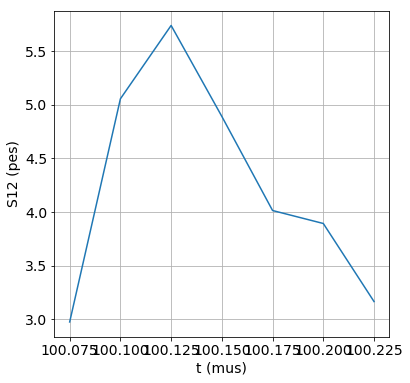

In [23]:
plot_s12(s1)

In [24]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      9.5 mus , energy =  24890.4 pes
        height =   6121.2 pes tmin-tmax = minmax(min=288.85, max=298.35) mus  

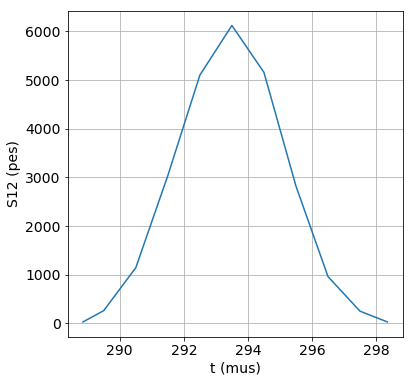

In [25]:
plot_s12(s2)

#### S2Si

In [26]:
s2si

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      9.5 mus , energy =  24890.4 pes
        height =   6121.2 pes tmin-tmax = minmax(min=288.85, max=298.35) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (721, 722, 723, 728, 729, 730, 731, 737, 738, 739, 745, 746)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 721
    sipm waveform (zs) = Peak(samples = 6 width =      5.0 mus , energy =     35.5 pes
        height =     14.9 pes tmin-tmax = minmax(min=290.5, max=295.5) mus 
peak number = 0: sipm number = 722
    sipm waveform (zs) = Peak(samples = 7 width =      6.0 mus , energy =     64.5 pes
        height =     16.8 pes tmin-tmax = minmax(min=290.5, max=296.5) mus 
peak number = 0: sipm number = 723
    sipm waveform (zs) = Peak(samples = 4 width =      3.0 mus , energy =     19.2 pe

In [27]:
s2si.number_of_peaks

1

In [28]:
s2si.sipms_in_peak(0)

(721, 722, 723, 728, 729, 730, 731, 737, 738, 739, 745, 746)

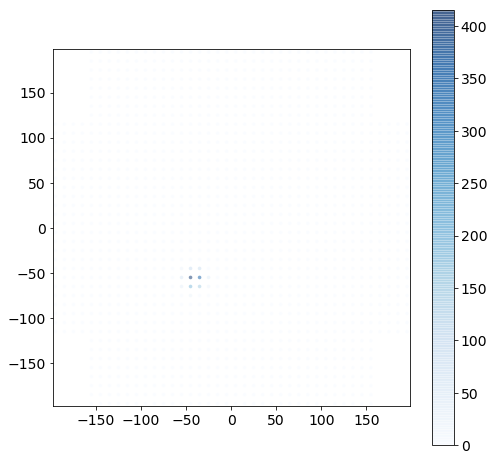

In [29]:
plot_s2si_map(s2si, run_number=-4446)

In [30]:
s1_t = s1.peak_waveform(0).tpeak
print('s1_t = {}'.format(s1_t))


s1_t = 100125.0


In [31]:
s2, s2si = rebin_s2si(s2, s2si, rebin=2)

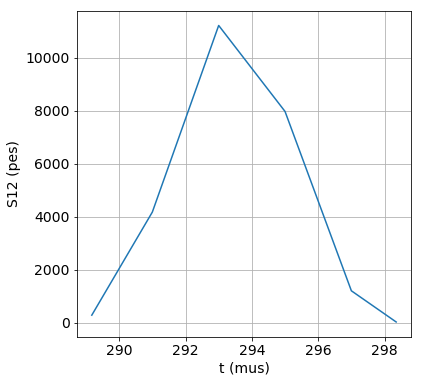

In [32]:
plot_s12(s2)

In [33]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 6 width =      9.2 mus , energy =  24890.4 pes
        height =  11220.9 pes tmin-tmax = minmax(min=289.175, max=298.35) mus  

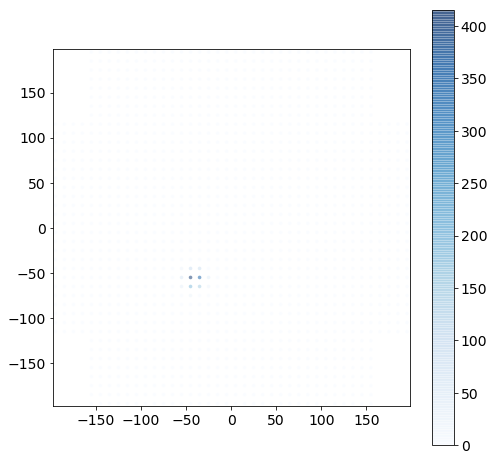

In [34]:
plot_s2si_map(s2si, run_number=-4446)

In [66]:
def compute_hits(event_number, event_time, s2si, Qthr=2 *units.pes, Qlm = 5* units.pes, msipm = 1): 
    hitc = HitCollection(event_number, event_time * 1e-3) 
    for peak_no, (t_peak, e_peak) in sorted(s2si.s2d.items()):
        for slice_no, (t_slice, e_slice) in enumerate(zip(t_peak, e_peak)):
            z        = (t_slice - s1_t) * units.ns * drift_v
            
            if DEB:
                print('Compute hits--\n')
                print('--peak_no = {} slice_no = {}\n'.format(peak_no, slice_no))
            try:
                clusters = compute_xy_position(s2si.s2sid[peak_no], slice_no, xs, ys, 
                                               Qthr=Qthr, 
                                               Qlm = Qlm, 
                                               lm_radius = 0, 
                                               new_lm_radius = 15 * units.mm, 
                                               msipm = msipm)
                
                es       = split_energy(e_slice, clusters)
                for c, e in zip(clusters, es):
                    hit       = Hit(peak_no, c, z, e)
                    hitc.hits.append(hit)
            except XYRecoFail:
                c = Cluster(NN, xy(0,0), xy(0,0), 0)
                hit       = Hit(peak_no, c, z, e_slice)
                hitc.hits.append(hit)

    return hitc


In [70]:
DEB=False

In [73]:
hitc = compute_hits(event_number, event_time, s2si, Qthr=2 *units.pes, Qlm = 5* units.pes, msipm = 1)

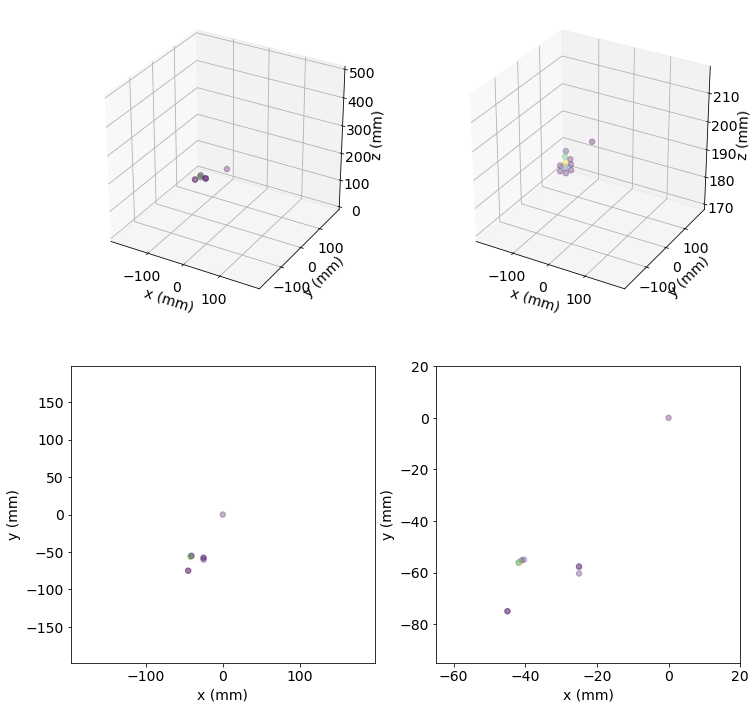

In [75]:
plot_hits_3D(hitc.hits, xsc=20, ysc=20, zsc=20)

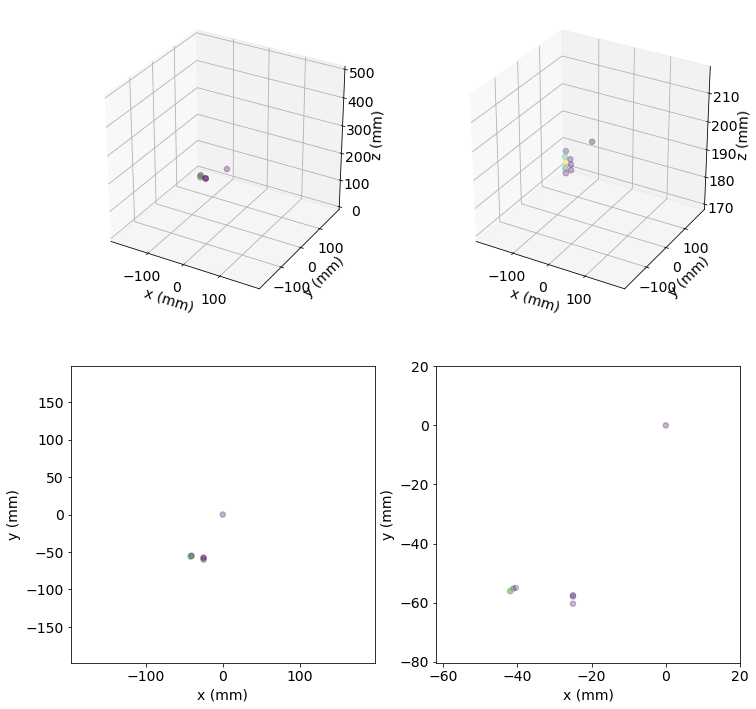

In [83]:
hitc = compute_hits(event_number, event_time, s2si, Qthr=2 *units.pes, Qlm = 5* units.pes, msipm = 2)
plot_hits_3D(hitc.hits, xsc=20, ysc=20, zsc=20)

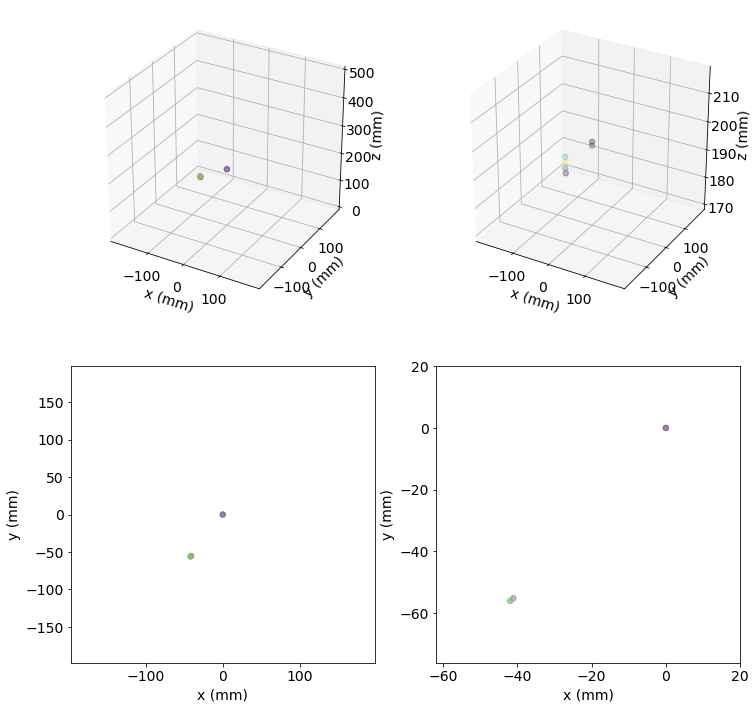

In [84]:
hitc = compute_hits(event_number, event_time, s2si, Qthr=2 *units.pes, Qlm = 5* units.pes, msipm = 3)
plot_hits_3D(hitc.hits, xsc=20, ysc=20, zsc=20)

#### msipm optimal may be at 1 or max 2

In [85]:
hitc = compute_hits(event_number, event_time, s2si, Qthr=2 *units.pes, Qlm = 5* units.pes, msipm = 1)

### Paolina

In [105]:
d = 16 * units.mm 
vox_size = np.array([d,d,d],dtype=np.int16)    # voxel size
blob_radius = 25.                    # blob radius in mm
voxel_size = Voxel(d, d, d, 1)

In [106]:
voxels = paf.voxelize_hits(hitc.hits, vox_size) 

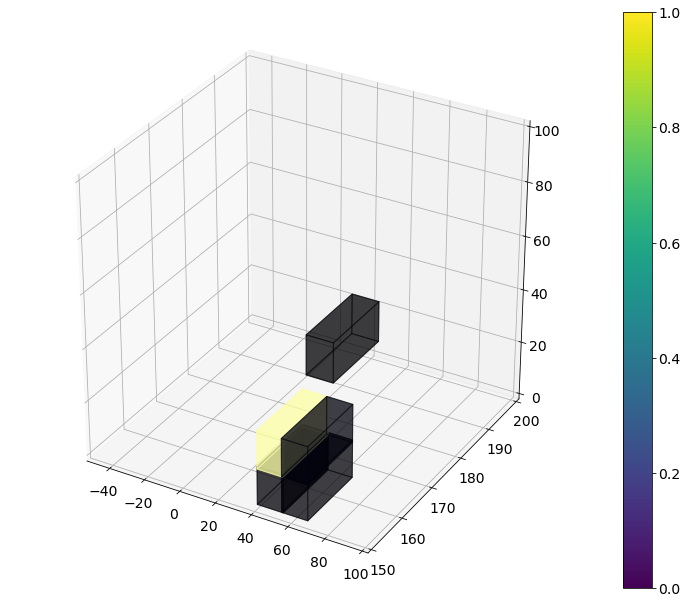

In [107]:
draw_voxels(voxels, voxel_size, xview=(-50, 100), yview=(150, 200), zview=(0, 100), alpha=0.5, colormap='inferno')

In [108]:
tc = paf.make_tracks(1, 1, voxels,
                     vox_size,
                     contiguity   = 1.5,
                     blob_radius  = blob_radius)

In [109]:
tc

TrackCollectionTrack list:Track: (number of voxels = 4)
,
                voxels = [<[-37.5, -67.5, 193.6375] 251.71774636713275>, <[-22.5, -52.5, 193.6375] 609.0484802421922>, <[-22.5, -67.5, 193.6375] 374.0093311352328>, <[-37.5, -52.5, 193.6375] 23627.53778530354>] 

                blob_a = Blob: (number of voxels = 4)
,
                voxels = [<[-22.5, -52.5, 193.6375] 609.0484802421922>, <[-22.5, -67.5, 193.6375] 374.0093311352328>, <[-37.5, -52.5, 193.6375] 23627.53778530354>, <[-37.5, -67.5, 193.6375] 251.71774636713275>] 

                seed   = <[-22.5, -52.5, 193.6375] 609.0484802421922> 

                blob energy = 24862.313343048096
         

                blob_b = Blob: (number of voxels = 4)
,
                voxels = [<[-37.5, -67.5, 193.6375] 251.71774636713275>, <[-22.5, -67.5, 193.6375] 374.0093311352328>, <[-37.5, -52.5, 193.6375] 23627.53778530354>, <[-22.5, -52.5, 193.6375] 609.0484802421922>] 

                seed   = <[-37.5, -67.5, 193.6375] 251.7177

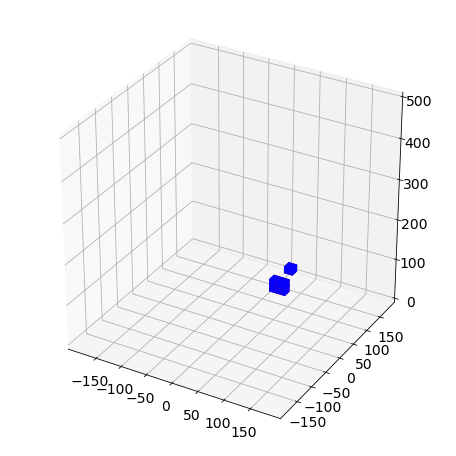

In [110]:
draw_tracks(tc, voxel_size)